In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#%load_ext memory_profiler
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
import scipy.ndimage
#POPPY
import poppy
from poppy.poppy_core import PlaneType
print("POPPY Version: "+poppy.__version__)
#silence DEBUG and WARNINGs
import logging
logging.getLogger('poppy').setLevel(logging.ERROR)
# MagAO-X function definitions
from model_kit import magaoxFunctions as mf
from model_kit import datafiles as dfx
# draw the dark hole regions
from skimage.draw import draw
# for writing files
from datetime import date
print('Last date this notebook was ran: {0}'.format(date.today()))
import copy

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

def rms(data):
    return np.sqrt(np.sum(np.square(data))/len(data))

POPPY Version: 0.9.2.dev11+g1887dd5
Last date this notebook was ran: 2021-11-10


In [2]:
# initial conditions
fr_parm = {'wavelength': 656e-9 * u.m,
           'npix': 538, # sample size
           'beam_ratio': 0.25, # oversample
           'leak_mult': 0.01,
           'n_tests': 10,
           'n_loop': 4,
           'set': 0,
           'bump': True,
           'wfe_data': 'allopd'} # other: 'allopd', 'common'

# set up prescription details
wavelen_str = str(np.round(fr_parm['wavelength'].to(u.nm).value).astype(int))
br = int(1/fr_parm['beam_ratio'])
parm_name = '{0:3}_{1:1}x_{2}nm'.format(fr_parm['npix'], br, wavelen_str)

# set up file locations
home_dir = '/home/jhen/XWCL/code/MagAOX/' # change for exao0
data_dir = home_dir + 'data/'
psd_dir = home_dir + 'PSD/model_parameters/'
psf_mask_dir = data_dir + 'mask_psf/'

vAPP_dir = data_dir+'data/coronagraph/'
vAPP_trans_filename = 'vAPP_trans_2PSF_{0}'.format(parm_name)
vAPP_posOPD_filename = 'vAPP_opd_2PSF_{0}_posPhase'.format(parm_name)
vAPP_negOPD_filename = 'vAPP_opd_2PSF_{0}_negPhase'.format(parm_name)

# open all the masks
top_circ = fits.open(psf_mask_dir + 'psf_top_circle_{0}.fits'.format(fr_parm['npix']))[0].data
bot_circ = fits.open(psf_mask_dir + 'psf_bot_circle_{0}.fits'.format(fr_parm['npix']))[0].data
top_dhmask = fits.open(psf_mask_dir + 'psf_top_dhmask_{0}.fits'.format(fr_parm['npix']))[0].data
bot_dhmask = fits.open(psf_mask_dir + 'psf_bot_dhmask_{0}.fits'.format(fr_parm['npix']))[0].data
tw_mask = fits.open(data_dir+'mask/lyot_tweeter_amp_mask_bump_538.fits')[0].data

In [3]:
# load the CSV prescription values
rx_loc_difflim = data_dir+'rxCSV/rx_magaox_NCPDM_sci_{0}_noap_{1}.csv'.format(parm_name, 
                                                                              'nowfe')
rx_difflim = mf.makeRxCSV(rx_loc_difflim)

# select the optics with some sort of wfe
# acquiring csv numerical values for specifically named optics
optic_name = []
optic_num = []
for t_optic, test_opt in enumerate(rx_difflim):        
    # Building the optic name and number list
    if (test_opt['Type'] == 'mirror' or test_opt['Type']=='DM'):
        optic_name.append(rx_difflim[t_optic]['Name'])
        optic_num.append(rx_difflim[t_optic]['Optical_Element_Number'])
optic_name.append('None')
optic_num.append(35)

### Data Processing
Skip the next couple cells until the figure plotting if the data isn't available locally.

In [ ]:
%%time
# Build the diffraction limited PSF without vAPP for Strehl calculation

# remove the vAPP
tweeter_num = 16
vappTRANS_num = 23
vappOPD_num = vappTRANS_num+1
rx_difflim['surf_PSD_filename'][vappTRANS_num] = 'none'
rx_difflim['surf_PSD_filename'][vappOPD_num] = 'none'

# calculate in POPPY
magaox = mf.csvFresnel(rx_csv=rx_difflim, 
                       samp=fr_parm['npix'], 
                       oversamp=fr_parm['beam_ratio'],
                       home_folder=home_dir, 
                       break_plane='F69Sci',
                       bump=fr_parm['bump'])
dl_psf = magaox.calc_psf(wavelength=fr_parm['wavelength'].value)[0]
dl_max = np.amax(dl_psf.data)

In [5]:
tot_opt = len(optic_num) # last one is for noneRemoved, calculated separately
tot_n = 2
tot_sets = tot_n*fr_parm['n_tests']

sr_closed = np.zeros((tot_opt, tot_sets))
ph_closed = np.zeros((tot_opt, tot_sets))
dh_top_closed = np.zeros((tot_opt, tot_sets))
dh_bot_closed = np.zeros((tot_opt, tot_sets))

# load all the 'none' set data
keepopd_closed = fits.open('data_reduce/fresnelmetric_allopd_closed_calpsd.fits')[0].data
keepopd_open = fits.open('data_reduce/fresnelmetric_allopd_open_calpsd.fits')[0].data
sr_open_avg = np.mean(keepopd_open[0][0:tot_sets])
ph_open_avg = np.mean(keepopd_open[1][0:tot_sets])
dh_top_open_avg = np.mean(keepopd_open[2][0:tot_sets])
dh_bot_open_avg = np.mean(keepopd_open[3][0:tot_sets])

fr_parm['wfe_data'] = 'allopd'
vapp_name = ['leak', 'pos', 'neg']

for ind in range(0, tot_opt):
    nst = 0 # incrementer
    ji = optic_num[ind]
    for ni in range(0, tot_n):
        # initialize the folder
        fr_folder = 'n{0}_{1}_{2}_tol_cal/'.format(ni, fr_parm['wfe_data'], fr_parm['npix'])
        
        for si in range(0, fr_parm['n_tests']):
            if ind==(tot_opt-1): # the 'none' case
                sr_closed[ind][nst] = keepopd_closed[0][nst]
                ph_closed[ind][nst] = keepopd_closed[1][nst]
                dh_top_closed[ind][nst] = keepopd_closed[2][nst]
                dh_bot_closed[ind][nst] = keepopd_closed[3][nst]
                
            else: # the rest of the stuff
                # SR - closed loop version
                sr_loc = 'psf_sr_{0}_s{1}_j{2}_i4_{3}nm.fits'.format(fr_parm['wfe_data'], si, 
                                                                     ji, wavelen_str)
                sr_fits = fits.open(fr_folder+sr_loc)[0].data
                sr_closed[ind][nst] = np.amax(sr_fits)/dl_max

                # wfs phase - closed loop
                ph_loc = 'wf_s{0}_j{1}_i4_phase.fits'.format(si, ji)
                ph_fits = fits.open(fr_folder+ph_loc)[0].data
                ph_closed[ind][nst] = rms(ph_fits[tw_mask==1])

                # build the psf
                loc_base = 'psf_mwfs_{0}_s{1}_j{2}_{3}nm_'.format(fr_parm['wfe_data'], si,
                                                                  ji, wavelen_str)
                psf_tot = np.zeros((fr_parm['npix'], fr_parm['npix']))
                for j_v in range(0, len(vapp_name)):
                    psf_data = fits.open(fr_folder+loc_base+'{0}.fits'.format(vapp_name[j_v]))[0].data
                    if vapp_name[j_v] == 'leak':
                        psf_data *= fr_parm['leak_mult']
                    psf_tot += psf_data
                    
                # save the total psf
                hdr = fits.open(fr_folder+loc_base+'{0}.fits'.format(vapp_name[j_v]))[0].header
                hdr['vapp_psf'] = ('total', 'vapp piece or full psf')
                hdr['leak_val'] = (fr_parm['leak_mult'], 'leak (0) phase psf multiplier')
                #fits.writeto(fr_folder+loc_base+'tot.fits', psf_tot, hdr, overwrite=True)

                # top psf
                psf_top_circ = psf_tot * top_circ
                psf_top_circ /= np.amax(psf_top_circ) # normalize to region
                dh_top_closed[ind][nst] = rms(psf_top_circ[top_dhmask==1])

                # bottom psf
                psf_bot_circ = psf_tot * bot_circ
                psf_bot_circ /= np.amax(psf_bot_circ) # normalize to region
                dh_bot_closed[ind][nst] = rms(psf_bot_circ[bot_dhmask==1])
            
            # iterate nst
            nst += 1

In [6]:
# Save the data
# write fits header
hdr = fits.Header()
hdr['comment'] = 'allopd, closed loop data'
hdr['comment'] = 'closed loop results only'
hdr['comment'] = 'psd set: uncalibrated mvls'
hdr['comment'] = 'rows: different optical surfaces'
hdr['comment'] = 'last row is noneRemoved'
hdr['comment'] = 'columns: different set psd sets'

fits.writeto('data_reduce/fresnelmetric_tol_{0}_strehl_calpsd.fits'.format(fr_parm['wfe_data']),
             sr_closed, hdr, overwrite=True)
fits.writeto('data_reduce/fresnelmetric_tol_{0}_wfsphase_calpsd.fits'.format(fr_parm['wfe_data']),
             ph_closed, hdr, overwrite=True)
fits.writeto('data_reduce/fresnelmetric_tol_{0}_dhtop_calpsd.fits'.format(fr_parm['wfe_data']),
             dh_top_closed, hdr, overwrite=True)
fits.writeto('data_reduce/fresnelmetric_tol_{0}_dhbot_calpsd.fits'.format(fr_parm['wfe_data']),
             dh_bot_closed, hdr, overwrite=True)

### Plots

In [7]:
tot_opt = len(optic_num) # last one is for noneRemoved, calculated separately
tot_n = 2
tot_sets = tot_n*fr_parm['n_tests']

# Open the data from the FITS files
sr_closed = fits.open('data_reduce/fresnelmetric_tol_{0}_strehl_calpsd.fits'.format(fr_parm['wfe_data']))[0].data
ph_closed = fits.open('data_reduce/fresnelmetric_tol_{0}_wfsphase_calpsd.fits'.format(fr_parm['wfe_data']))[0].data
dh_top_closed = fits.open('data_reduce/fresnelmetric_tol_{0}_dhtop_calpsd.fits'.format(fr_parm['wfe_data']))[0].data
dh_bot_closed = fits.open('data_reduce/fresnelmetric_tol_{0}_dhbot_calpsd.fits'.format(fr_parm['wfe_data']))[0].data

# open loop data
keepopd_open = fits.open('data_reduce/fresnelmetric_allopd_open_calpsd.fits')[0].data
sr_open_avg = np.mean(keepopd_open[0][0:tot_sets])
sr_open_std = np.std(keepopd_open[0][0:tot_sets])
ph_open_avg = np.mean(keepopd_open[1][0:tot_sets])
ph_open_std = np.std(keepopd_open[1][0:tot_sets])
dh_top_open_avg = np.mean(keepopd_open[2][0:tot_sets])
dh_top_open_std = np.std(keepopd_open[2][0:tot_sets])
dh_bot_open_avg = np.mean(keepopd_open[3][0:tot_sets])
dh_bot_open_std = np.std(keepopd_open[3][0:tot_sets])

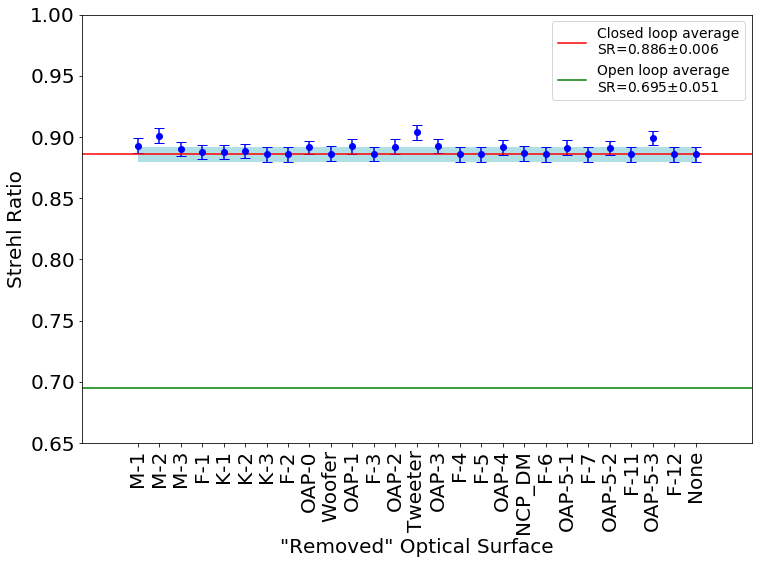

In [17]:
# Strehl
sr_avg = np.mean(sr_closed, axis=1)
sr_std = np.std(sr_closed, axis=1)

matplotlib.rcParams["font.size"]=20
plt.figure(figsize=[12,7], facecolor='white')
# individual dots and error bar lines
plt.errorbar(optic_name,sr_avg, yerr=sr_std, fmt='o', color='b',
             capsize=5)

# closed loop control std dev region
plt.fill_between(np.arange(len(optic_name)),
                 sr_avg[-1]+sr_std[-1],
                 sr_avg[-1]-sr_std[-1],
                 facecolor='powderblue', alpha=1.0, edgecolor='none')

# closed loop control horz line
plt.axhline(sr_avg[-1], color='r', 
            label='Closed loop average\nSR={0:.3f}$\pm${1:.3f}'.format(sr_avg[-1], 
                                                                       sr_std[-1]))

# open loop control horz line
plt.axhline(sr_open_avg, color='g', 
            label='Open loop average\nSR={0:.3f}$\pm${1:.3f}'.format(sr_open_avg,
                                                                     sr_open_std))

# labels
plt.xlabel('"Removed" Optical Surface')
plt.ylabel('Strehl Ratio')
plt.legend(loc='upper right', fontsize='x-small')
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
x=np.arange(len(optic_num))
plt.xticks(x,optic_name,rotation='vertical')
plt.ylim(top=1, bottom=0.65)
plt.margins(0.1)
plt.subplots_adjust(top=1.0)
plt.subplots_adjust(bottom=0.15)
#plt.title('Strehl Ratio analysis, 20 PSD set',y=1.05)
plt.show()

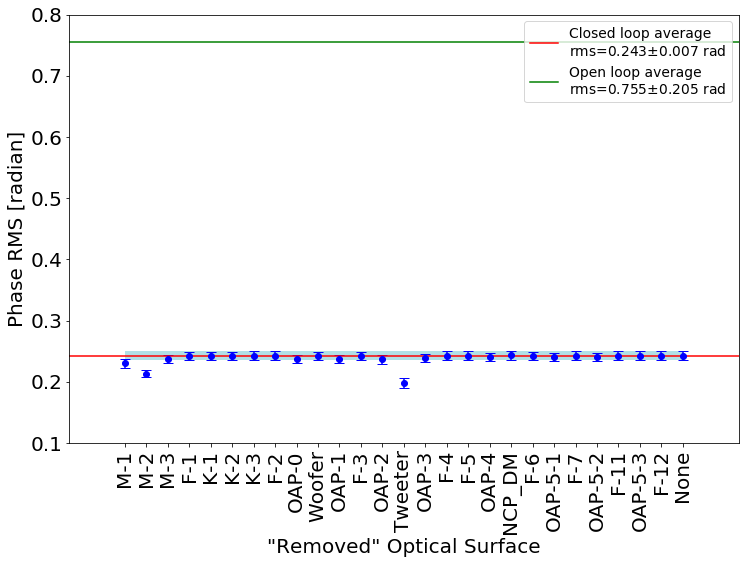

In [16]:
# WFS Phase Error
ph_avg = np.mean(ph_closed, axis=1)
ph_std = np.std(ph_closed, axis=1)

matplotlib.rcParams["font.size"]=20
plt.figure(figsize=[12,7], facecolor='white')
# individual dots and error bar lines
plt.errorbar(optic_name,ph_avg, yerr=ph_std, fmt='o', color='b', capsize=5)

# closed loop control std dev region
plt.fill_between(np.arange(len(optic_name)),
                 ph_avg[-1]+ph_std[-1],
                 ph_avg[-1]-ph_std[-1],
                 facecolor='powderblue', alpha=1.0, edgecolor='none')

# closed loop control horz line
plt.axhline(ph_avg[-1], color='r', 
            label='Closed loop average\nrms={0:.3f}$\pm${1:.3f} rad'.format(ph_avg[-1],
                                                                            ph_std[-1]))

# open loop control horz line
plt.axhline(ph_open_avg, color='g', 
            label='Open loop average\nrms={0:.3f}$\pm${1:.3f} rad'.format(ph_open_avg,
                                                                      ph_open_std))

# labels
plt.xlabel('"Removed" Optical Surface')
plt.ylabel('Phase RMS [radian]')
plt.ylim(top=0.8, bottom=0.1)
plt.legend(loc='upper right', fontsize='x-small')
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
x=np.arange(len(optic_num))
plt.xticks(x,optic_name,rotation='vertical')
plt.margins(0.1)
plt.subplots_adjust(top=1.0)
plt.subplots_adjust(bottom=0.15)
#plt.title('WFS phase RMS analysis, 20 PSD set',y=1.05)
plt.show()

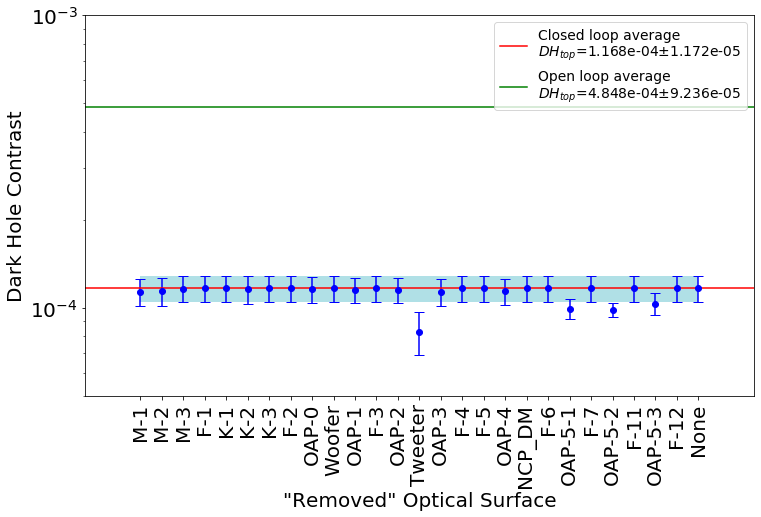

In [15]:
# Top Dark Hole
top_dh_avg = np.mean(dh_top_closed, axis=1)
top_dh_std = np.std(dh_top_closed, axis=1)

matplotlib.rcParams["font.size"]=20
plt.figure(figsize=[12,7], facecolor='white')
plt.yscale('log')
# individual dots and error bar lines
plt.errorbar(optic_name,top_dh_avg, yerr=top_dh_std, fmt='o', color='b', capsize=5)

# closed loop control std dev region
plt.fill_between(np.arange(len(optic_name)),
                 top_dh_avg[-1]+top_dh_std[-1],
                 top_dh_avg[-1]-top_dh_std[-1],
                 facecolor='powderblue', alpha=1.0, edgecolor='none')

# closed loop control horz line
plt.axhline(top_dh_avg[-1], color='r', 
            label='Closed loop average\n{0}={1:.3e}$\pm${2:.3e}'.format(r'$DH_{top}$',
                                                                        top_dh_avg[-1],
                                                                        top_dh_std[-1]))

# open loop control horz line
plt.axhline(dh_top_open_avg, color='g', 
            label='Open loop average\n{0}={1:.3e}$\pm${2:.3e}'.format(r'$DH_{top}$',
                                                                      dh_top_open_avg,
                                                                      dh_top_open_std))

# labels
plt.xlabel('"Removed" Optical Surface')
plt.ylabel('Dark Hole Contrast')
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ylim(top=1e-3, bottom=5e-5)
plt.legend(loc='upper right', fontsize='x-small')
x=np.arange(len(optic_num))
plt.xticks(x,optic_name,rotation='vertical')
plt.margins(0.1)
#plt.subplots_adjust(top=1.0)
#plt.subplots_adjust(bottom=0.15)
#plt.title('Top DH, 20 PSD set',y=1.05)
plt.show()

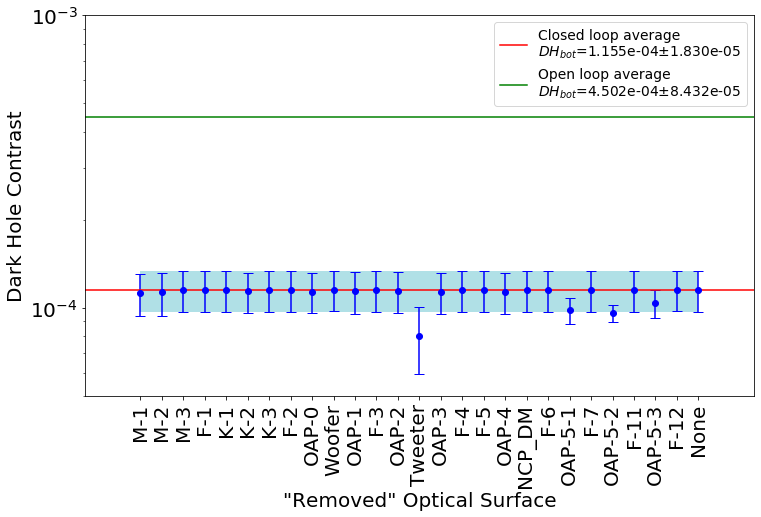

In [19]:
# Bottom Dark Hole
bot_dh_avg = np.mean(dh_bot_closed, axis=1)
bot_dh_std = np.std(dh_bot_closed, axis=1)

matplotlib.rcParams["font.size"]=20
plt.figure(figsize=[12,7], facecolor='white')
plt.yscale('log')
# individual dots and error bar lines
plt.errorbar(optic_name,bot_dh_avg, yerr=bot_dh_std, fmt='o', color='b', capsize=5)

# closed loop control std dev region
plt.fill_between(np.arange(len(optic_name)),
                 bot_dh_avg[-1]+bot_dh_std[-1],
                 bot_dh_avg[-1]-bot_dh_std[-1],
                 facecolor='powderblue', alpha=1.0, edgecolor='none')

# closed loop control horz line
plt.axhline(bot_dh_avg[-1], color='r', 
            label='Closed loop average\n{0}={1:.3e}$\pm${2:.3e}'.format(r'$DH_{bot}$',
                                                                        bot_dh_avg[-1],
                                                                        bot_dh_std[-1]))

# open loop control horz line
plt.axhline(dh_bot_open_avg, color='g', 
            label='Open loop average\n{0}={1:.3e}$\pm${2:.3e}'.format(r'$DH_{bot}$',
                                                                      dh_bot_open_avg,
                                                                      dh_bot_open_std))

# labels
plt.xlabel('"Removed" Optical Surface')
plt.ylabel('Dark Hole Contrast')
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ylim(top=1e-3, bottom=5e-5)
plt.legend(loc='upper right', fontsize='x-small')
x=np.arange(len(optic_num))
plt.xticks(x,optic_name,rotation='vertical')
plt.margins(0.1)
#plt.subplots_adjust(top=1.0)
#plt.subplots_adjust(bottom=0.15)
#plt.title('Bot DH, 20 PSD set',y=1.05)
plt.show()